# Latent Dirichlet Allocation (LDA)

There are many approaches for obtaining topics from a text such as – Term Frequency and Inverse Document Frequency. NonNegative Matrix Factorization techniques. 

LDA assumes documents are produced from a mixture of topics. Those topics then generate words based on their probability distribution. Given a dataset of documents, LDA backtracks and tries to figure out what topics would create those documents in the first place.

LDA is a matrix factorization technique. In vector space, any corpus (collection of documents) can be represented as a document-term matrix. The following matrix shows a corpus of N documents D1, D2, D3 … Dn and vocabulary size of M words W1,W2 .. Wn. The value of i,j cell gives the frequency count of word Wj in Document Di.

![](https://www.analyticsvidhya.com/wp-content/uploads/2016/08/Modeling2.png)

LDA converts this Document-Term Matrix into two lower dimensional matrices – M1 and M2.
M1 is a document-topics matrix and M2 is a topic – terms matrix with dimensions (N,  K) and (K, M) respectively, where N is the number of documents, K is the number of topics and M is the vocabulary size.

![](https://www.analyticsvidhya.com/wp-content/uploads/2016/08/modeling3.png)

![](https://www.analyticsvidhya.com/wp-content/uploads/2016/08/Modeling4.png)

Notice that these two matrices already provides topic word and document topic distributions, However, these distribution needs to be improved, which is the main aim of LDA. LDA makes use of sampling techniques in order to improve these matrices.

It Iterates through each word “w” for each document “d” and tries to adjust the current topic – word assignment with a new assignment. A new topic “k” is assigned to word “w” with a probability P which is a product of two probabilities p1 and p2.

For every topic, two probabilities p1 and p2 are calculated. P1 – p(topic t / document d) = the proportion of words in document d that are currently assigned to topic t. P2 – p(word w / topic t) = the proportion of assignments to topic t over all documents that come from this word w.

The current topic – word assignment is updated with a new topic with the probability, product of p1 and p2 . In this step, the model assumes that all the existing word – topic assignments except the current word are correct. This is essentially the probability that topic t generated word w, so it makes sense to adjust the current word’s topic with new probability.

After a number of iterations, a steady state is achieved where the document topic and topic term distributions are fairly good. This is the convergence point of LDA.

**Parameters of LDA**
1. **Alpha and Beta Hyperparameters** – alpha represents document-topic density and Beta represents topic-word density. Higher the value of alpha, documents are composed of more topics and lower the value of alpha, documents contain fewer topics. On the other hand, higher the beta, topics are composed of a large number of words in the corpus, and with the lower value of beta, they are composed of few words.

2. **Number of Topics** – Number of topics to be extracted from the corpus. Researchers have developed approaches to obtain an optimal number of topics by using Kullback Leibler Divergence Score. I will not discuss this in detail, as it is too mathematical. For understanding, one can refer to this[1] original paper on the use of KL divergence.

3. **Number of Topic Terms** – Number of terms composed in a single topic. It is generally decided according to the requirement. If the problem statement talks about extracting themes or concepts, it is recommended to choose a higher number, if problem statement talks about extracting features or terms, a low number is recommended.

4. **Number of Iterations / passes** – Maximum number of iterations allowed to LDA algorithm for convergence.


## The Authors and their works

1. **[EAP - Edgar Allen Poe](https://en.wikipedia.org/wiki/Edgar_Allan_Poe)** : American writer who wrote poetry and short stories that revolved around tales of mystery and the grisly and the grim. Arguably his most famous work is the poem - "The Raven" and he is also widely considered the pioneer of the genre of the detective fiction. 

2. **[HPL - HP Lovecraft](https://en.wikipedia.org/wiki/H._P._Lovecraft)** : Best known for authoring works of horror fiction, the stories that he is most celebrated for revolve around the fictional mythology of the infamous creature "Cthulhu" - a hybrid chimera mix of Octopus head and humanoid body with wings on the back.

3. **[MWS - Mary Shelley](https://en.wikipedia.org/wiki/Mary_Shelley)** : Seemed to have been involved in a whole panoply of literary pursuits - novelist, dramatist, travel-writer, biographer. She is most celebrated for the classic tale of Frankenstein where the scientist Frankenstein a.k.a "The Modern Prometheus" creates the Monster that comes to be associated with his name.

In [37]:
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True) #to show plotted graph
from imageio import imread
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
import base64 
import codecs
import nltk

# 1. Data Visualization

In [2]:
train = pd.read_csv(r"C:\Users\LW130003\Documents\GitHub\spooky-author-identification/train.csv")
test = pd.read_csv(r"C:\Users\LW130003\Documents\GitHub\spooky-author-identification/test.csv")
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [3]:
print('Number of rows: {}'.format(train.shape[0]))
print('Number of columns: {}'.format(train.shape[1]))

Number of rows: 19579
Number of columns: 3


## 1.1. Bar plot

In [4]:
z = {'EAP': 'Edgar Allen Poe', 'MWS': 'Mary Shelley', 'HPL': 'HP Lovecraft'}
data = [go.Bar(
            x = train.author.map(z).unique(),
            y = train.author.value_counts().values,
            marker= dict(colorscale='Jet',
                         color = train.author.value_counts().values
                        ),
            text='Text entries attributed to Author'
    )]

layout = go.Layout(
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [5]:
all_words = train['text'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the training dataset'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [6]:
eap = train[train.author=="EAP"]["text"].values
hpl = train[train.author=="HPL"]["text"].values
mws = train[train.author=="MWS"]["text"].values

Above, we notice that the words appearing in the word frequency plot are commonly occuring words which you could find in any english text. Therefore we have to find some way to preprocess our datset first to strip out all these commonly occuring wordds which do not bring much to the table.

## 1.2. WordClouds

A word cloud is an image that is made up of a mixture of distinct words which may make up a text or book and where the size of each word is proportional to its word frequency in that text (number of times the word appears). 

The image for wordcloud mask could be found in the **[github page](https://github.com/LW130003/spooky-author-identification)**.

In [7]:
eap_64 = open(r'C:\Users\LW130003\Documents\GitHub\spooky-author-identification\raven.txt','a')

In [8]:
image = open(r'C:\Users\LW130003\Documents\GitHub\spooky-author-identification\raven.jpg','rb')
image_read = image.read()
eap_64 = base64.encodebytes(image_read)

image = open(r'C:\Users\LW130003\Documents\GitHub\spooky-author-identification\cthulhu.jpg','rb')
image_read = image.read()
hpl_64 = base64.encodebytes(image_read)

image = open(r'C:\Users\LW130003\Documents\GitHub\spooky-author-identification\frankenstein.jpg','rb')
image_read = image.read()
mws_64 = base64.encodebytes(image_read)

In [9]:
import codecs
# Generate the Mask for EAP
f1 = open("eap.png", "wb")
f1.write(codecs.decode(eap_64,'base64'))
f1.close()
img1 = imread("eap.png")
# img = img.resize((980,1080))
hcmask = img1

f2 = open("hpl.png", "wb")
f2.write(codecs.decode(hpl_64,'base64'))
f2.close()
img2 = imread("hpl.png")
hcmask2 = img2

f3 = open("mws.png", "wb")
f3.write(codecs.decode(mws_64,'base64'))
f3.close()
img3 = imread("mws.png")
hcmask3 = img3

(-0.5, 391.5, 391.5, -0.5)

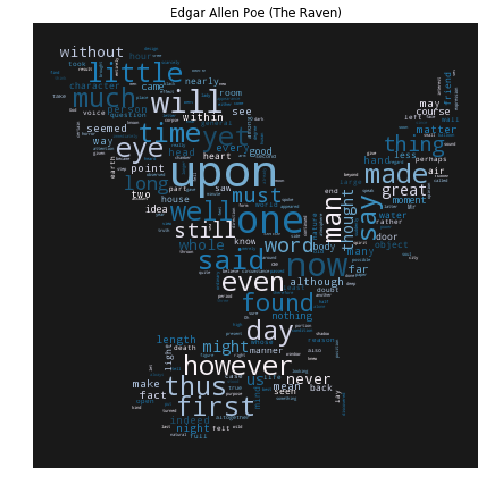

In [10]:
#wordcloud of the raven for Edgar Allen Poe
plt.figure(figsize=(20,18))
plt.subplot(211)
wc = WordCloud(background_color="black", max_words=10000, 
               mask=hcmask, stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(eap))
plt.title("Edgar Allen Poe (The Raven)")
plt.imshow(wc.recolor( colormap= 'PuBu' , random_state=17), alpha=0.9)
plt.axis('off')

(-0.5, 563.5, 662.5, -0.5)

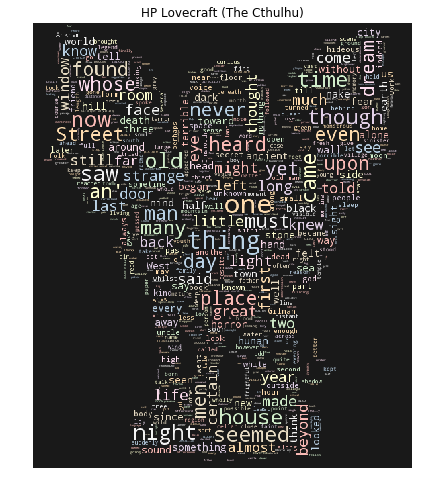

In [11]:
#wordcloud of the cthulhu for HP Lovecraft
plt.figure(figsize=(20,18))
plt.subplot(211)
wc = WordCloud(background_color="black", max_words=10000, 
               mask=hcmask2, stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(hpl))
plt.title("HP Lovecraft (The Cthulhu)")
plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.9)
plt.axis('off')

(-0.5, 644.5, 369.5, -0.5)

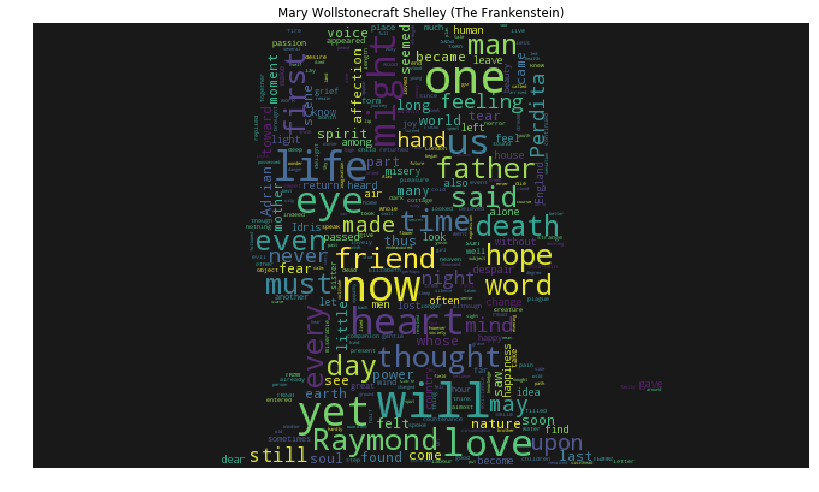

In [12]:
#wordcloud of the frankenstein for Mary W. Shelley
plt.figure(figsize=(20,18))
plt.subplot(211)
wc = WordCloud(background_color="black", max_words=10000, 
               mask=hcmask3, stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(mws))
plt.title("Mary Wollstonecraft Shelley (The Frankenstein)")
plt.imshow(wc.recolor( colormap= 'viridis' , random_state=17), alpha=0.9)
plt.axis('off')

# 2. Natural Language Processing (NLP)
Here, we use Natural Language Toolkit (NLTK) libraries for NLP. First, we will do some testing before creating a class to process the text data.

## 2.1 Tokenization

Tokenization is segregation of the text into its individual constitutent words.

In [13]:
#storing the first text element as a string
first_text = train.text.values[0]

#tokenization with split() method
print(first_text)
print("="*90)
print(first_text.split(" "))

This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
['This', 'process,', 'however,', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon;', 'as', 'I', 'might', 'make', 'its', 'circuit,', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out,', 'without', 'being', 'aware', 'of', 'the', 'fact;', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall.']


In [14]:
#tokenization with word_tokenize() method from nltk libraries
first_text_list = nltk.word_tokenize(first_text)
print(first_text_list)

['This', 'process', ',', 'however', ',', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon', ';', 'as', 'I', 'might', 'make', 'its', 'circuit', ',', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out', ',', 'without', 'being', 'aware', 'of', 'the', 'fact', ';', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall', '.']


## 2.2 Stopword Removal

Stopword Removal is removing any words that occur too frequently as its frequency of occurrence will not be useful in helping detecting relevant texts. (as an aside also consider throwing away words that occur too infrequently). For example, stopwords include terms such as "to" or "the". Conveniently, NLTK comes with a predefined list of 153 english stopwords.

In [15]:
stopwords = nltk.corpus.stopwords.words('english')
len(stopwords)

153

In [16]:
first_text_list_cleaned = [word for word in first_text_list if word.lower() not in stopwords]
print(first_text_list_cleaned)
print("="*90)
print("Length of original list: {0} words\n"
      "Length of list after stopwords removal: {1} words"
      .format(len(first_text_list), len(first_text_list_cleaned)))

['process', ',', 'however', ',', 'afforded', 'means', 'ascertaining', 'dimensions', 'dungeon', ';', 'might', 'make', 'circuit', ',', 'return', 'point', 'whence', 'set', ',', 'without', 'aware', 'fact', ';', 'perfectly', 'uniform', 'seemed', 'wall', '.']
Length of original list: 48 words
Length of list after stopwords removal: 28 words


## 2.3. Stemming and Lemmatization

### 2.3.1 Stemming
Stemming is combining variants of words into a single parent word that still conveys the same meaning. For example, "running", "runs" and "run" could be combined into "run".
NLTK provides various stemmers which include variants such as the Porter stemming algorithm, the lancaster stemmer and the Snowball stemmer. In the following example, we will create a porter stemmer instance as follows:

In [17]:
stemmer = nltk.stem.PorterStemmer()
print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))

The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


As we can see, the stemmer has successfully reduced the given words above into a base form and this will be most in helping us reduce the size of our dataset of words when we come to learning and classification tasks.

However there is one flaw with stemming and that is the fact that the process involves quite a [crude heuristic in chopping off the ends of words](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) in the hope of reducing a particular word into a human recognizable base form. Therefore this process does not take into account vocabulary or word forms when collapsing words as this example will illustrate:

In [18]:
print("The stemmed form of leaves is: {}".format(stemmer.stem("leaves")))

The stemmed form of leaves is: leav


### 2.3.2 Lemmatization

To fix the issue above, we are going to used a method called lemmatization. This method aims to achieve the same effect as the former method. However unlike a stemmer, lemmatizing the dataset aims to reduce words based on an actual dictionary or vocabulary (the Lemma) and therefore will not chop off words into stemmed forms that do not carry any lexical meaning. Here we can utilize NLTK once again to initialize a lemmatizer (WordNet variant) and inspect how it collapses words as follows:

In [19]:
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("leaves")))

The lemmatized form of leaves is: leaf


### 2.4. Vectorization

Vectorization is converting text into vector format. One of the simplest is the famous bag-of-words approach, where you create a matrix (for each document or text in the corpus). In the simplest form, this matrix stores word frequencies (word counts) and is oft referred to as vectorization of the raw text. 
2d. Vectorizing Raw Text

In [20]:
#Bags of words apporach with CountVectorizer method from sklearn

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
sentence = ["I love to eat Burgers", 
            "I love to eat Fries"]
vectorizer = CountVectorizer(min_df=0)

#fittinng the vectorizer to the dataset
sentence_transform = vectorizer.fit_transform(sentence)
print(sentence_transform)

print('='*70)
#get_feature_names to inspect the sparse matrix
print("The features are:\n {}".format(vectorizer.get_feature_names()))
print("\nThe vectorized array looks like:\n {}".format(sentence_transform.toarray()))

print('='*70)
sentence_transform

  (0, 0)	1
  (0, 1)	1
  (0, 4)	1
  (0, 3)	1
  (1, 2)	1
  (1, 1)	1
  (1, 4)	1
  (1, 3)	1
The features are:
 ['burgers', 'eat', 'fries', 'love', 'to']

The vectorized array looks like:
 [[1 1 0 1 1]
 [0 1 1 1 1]]


<2x5 sparse matrix of type '<class 'numpy.int64'>'
	with 8 stored elements in Compressed Sparse Row format>

## 2.5 Combine everything into one

In [21]:
#define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)
        
#putting all preprocessing steps together

#extending CountVectorizer with lemmatizer
lemm = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))
    
# Storing the entire training text in a list
text = list(train.text.values)
# Calling our overwritten Count vectorizer
tf_vectorizer = LemmaCountVectorizer(max_df=0.95, min_df=2,
                                          stop_words='english',
                                          decode_error='ignore')
tf = tf_vectorizer.fit_transform(text)

**Plot the word importance again**

In [22]:
feature_names = tf_vectorizer.get_feature_names()
count_vec = np.asarray(tf.sum(axis=0)).ravel()
zipped = list(zip(feature_names, count_vec))
x, y = (list(x) for x in zip(*sorted(zipped, key=lambda x: x[1], reverse=True)))
# Now I want to extract out on the top 15 and bottom 15 words
Y = np.concatenate([y[0:15], y[-16:-1]])
X = np.concatenate([x[0:15], x[-16:-1]])

# Plotting the Plot.ly plot for the Top 50 word frequencies
data = [go.Bar(
            x = x[0:50],
            y = y[0:50],
            marker= dict(colorscale='Jet',
                         color = y[0:50]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 Word frequencies after Preprocessing'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

# Plotting the Plot.ly plot for the Top 50 word frequencies
data = [go.Bar(
            x = x[-100:],
            y = y[-100:],
            marker= dict(colorscale='Portland',
                         color = y[-100:]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Bottom 100 Word frequencies after Preprocessing'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

# 3. Topic modelling via LDA and NMF

1. **Latent Dirichlet Allocation** - Probabilistic, generative model which uncovers the topics latent to a dataset by assigning weights to words in a corpus, where each topic will assign different probability weights to each word. 

2. **Non-negative Matrix Factorization** - Approximation method that takes an input matrix and approximates the factorization of this matrix into two other matrices, with the caveat that the values in the matrix be non-negative.

## 3.1. LDA

The LDA algorithm first models documents via a mixture model of topics. From these topics, words are then assigned weights based on the probability distribution of these topics. It is this probabilistic assignment over words that allow a user of LDA to say how likely a particular word falls into a topic. Subsequently from the collection of words assigned to a particular topic, are we thus able to gain an insight as to what that topic may actually represent from a lexical point of view.

From a standard LDA model, there are really a few key parameters that we have to keep in mind and consider programmatically tuning before we invoke the model:
1. n_components: The number of topics that you specify to the model
2. $\alpha$ parameter: This is the dirichlet parameter that can be linked to the document topic prior 
3. $\beta$ parameter: This is the dirichlet parameter linked to the topic word prior

In [38]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))
lda = LatentDirichletAllocation(n_components=6, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(tf)

The nltk version is 3.2.3.
The scikit-learn version is 0.19.1.


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=6, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

**Topics generated by LDA**

We will utilise our helper function we defined earlier "print_top_words" to return the top 10 words attributed to each of the LDA generated topics. To select the number of topics, this is handled through the parameter n_components in the function.

In [24]:
n_top_words = 10
print("\nTopics in LDA model: ")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model: 

Topic #0:wall did think make fact mean say human like good

Topic #1:death life time length man dead said nearly present body

Topic #2:man said word left earth say eye hand fear let

Topic #3:hour strange light mother room ancient longer large city sense

Topic #4:day house heart love door life hope shall new soul

Topic #5:thing thought saw mind old dream did night father time


In [25]:
first_topic = lda.components_[0]
second_topic = lda.components_[1]
third_topic = lda.components_[2]

first_topic.shape

(13781,)

In [26]:
first_topic_words = [tf_feature_names[i] for i in first_topic.argsort()[:-50 - 1 :-1]]
second_topic_words = [tf_feature_names[i] for i in second_topic.argsort()[:-50 - 1 :-1]]
third_topic_words = [tf_feature_names[i] for i in third_topic.argsort()[:-50 - 1 :-1]]

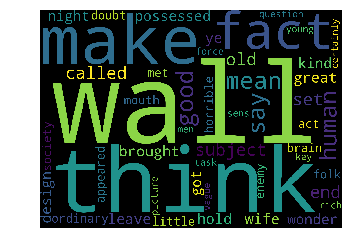

In [27]:
# Generating the wordcloud with the values under the category dataframe
firstcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(first_topic_words))
plt.imshow(firstcloud)
plt.axis('off')
plt.show()

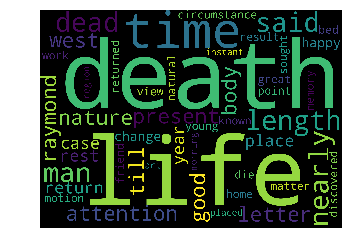

In [28]:
# Generating the wordcloud with the values under the category dataframe
secondcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(second_topic_words))
plt.imshow(secondcloud)
plt.axis('off')
plt.show()

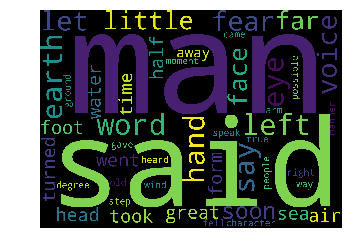

In [29]:
# Generating the wordcloud with the values under the category dataframe
thirdcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(third_topic_words))
plt.imshow(thirdcloud)
plt.axis('off')
plt.show()

In [ ]:
## 3.2. NMF

In [30]:
nmf = NMF(n_components=6, max_iter=5, random_state=0)
nmf.fit(tf)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=5,
  n_components=6, random_state=0, shuffle=False, solver='cd', tol=0.0001,
  verbose=0)

In [31]:
n_top_words = 10
print("\nTopics in NMF model: ")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in NMF model: 

Topic #0:wall did think make fact mean say human like good

Topic #1:death life time length man dead said nearly present body

Topic #2:man said word left earth say eye hand fear let

Topic #3:hour strange light mother room ancient longer large city sense

Topic #4:day house heart love door life hope shall new soul

Topic #5:thing thought saw mind old dream did night father time


In [32]:
first_topic = lda.components_[0]
second_topic = lda.components_[1]
third_topic = lda.components_[2]

first_topic.shape

(13781,)

In [33]:
first_topic_words = [tf_feature_names[i] for i in first_topic.argsort()[:-50 - 1 :-1]]
second_topic_words = [tf_feature_names[i] for i in second_topic.argsort()[:-50 - 1 :-1]]
third_topic_words = [tf_feature_names[i] for i in third_topic.argsort()[:-50 - 1 :-1]]

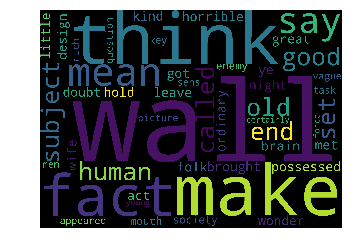

In [34]:
# Generating the wordcloud with the values under the category dataframe
firstcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(first_topic_words))
plt.imshow(firstcloud)
plt.axis('off')
plt.show()

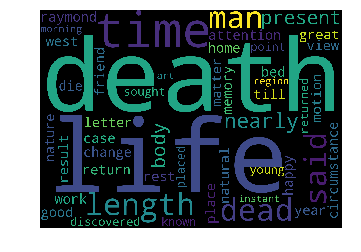

In [35]:
# Generating the wordcloud with the values under the category dataframe
secondcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(second_topic_words))
plt.imshow(secondcloud)
plt.axis('off')
plt.show()

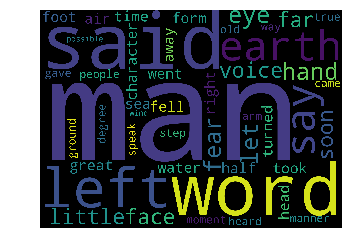

In [36]:
# Generating the wordcloud with the values under the category dataframe
thirdcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(third_topic_words))
plt.imshow(thirdcloud)
plt.axis('off')
plt.show()

![](https://image.slidesharecdn.com/ldatutorial-150317223352-conversion-gate01/95/topic-modeling-for-learning-analytics-researchers-lak15-tutorial-15-638.jpg?cb=1426894536)